#### load libs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import happycolors

%matplotlib inline

#### import the ice

In [2]:
trainDataPath = '../DataSets/iceberg/train.json'

trainData = pd.read_json(trainDataPath)

##### check out data

In [3]:
trainData.shape

(1604, 5)

### generate some mathematical values

#### median

In [4]:
trainData['band_1_median'] = trainData['band_1'].apply(lambda x: np.median(x))
trainData['band_2_median'] = trainData['band_2'].apply(lambda x: np.median(x))

#### mean

In [5]:
trainData['band_1_mean'] = trainData['band_1'].apply(lambda x: np.mean(x))
trainData['band_2_mean'] = trainData['band_2'].apply(lambda x: np.mean(x))

#### std

In [6]:
trainData['band_1_std'] = trainData['band_1'].apply(lambda x: np.std(x))
trainData['band_2_std'] = trainData['band_2'].apply(lambda x: np.std(x))

#### each element of band gets its own column

In [7]:
band_1_as_cols = trainData.apply(lambda x: pd.Series(x['band_1']), axis=1)
band_2_as_cols = trainData.apply(lambda x: pd.Series(x['band_2']), axis=1)

In [8]:
band_1_as_cols.columns = ['band_1_' + str(col) for col in band_1_as_cols.columns]
band_2_as_cols.columns = ['band_2_' + str(col) for col in band_2_as_cols.columns]

In [9]:
trainData = pd.concat([trainData, band_1_as_cols, band_2_as_cols], axis=1)

In [14]:
trainData = trainData.drop(["band_1", "band_2"], axis=1)

#### seperate traindata w/o traindata

In [7]:
na_trainData = trainData[trainData['inc_angle'].str.contains("na")==True]

In [8]:
trainData = trainData.drop(na_trainData.index)

#### look at angle distribution

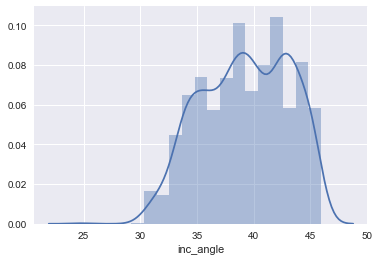

In [11]:
sns.distplot(trainData['inc_angle'])
plt.show()

#### combine interesting data

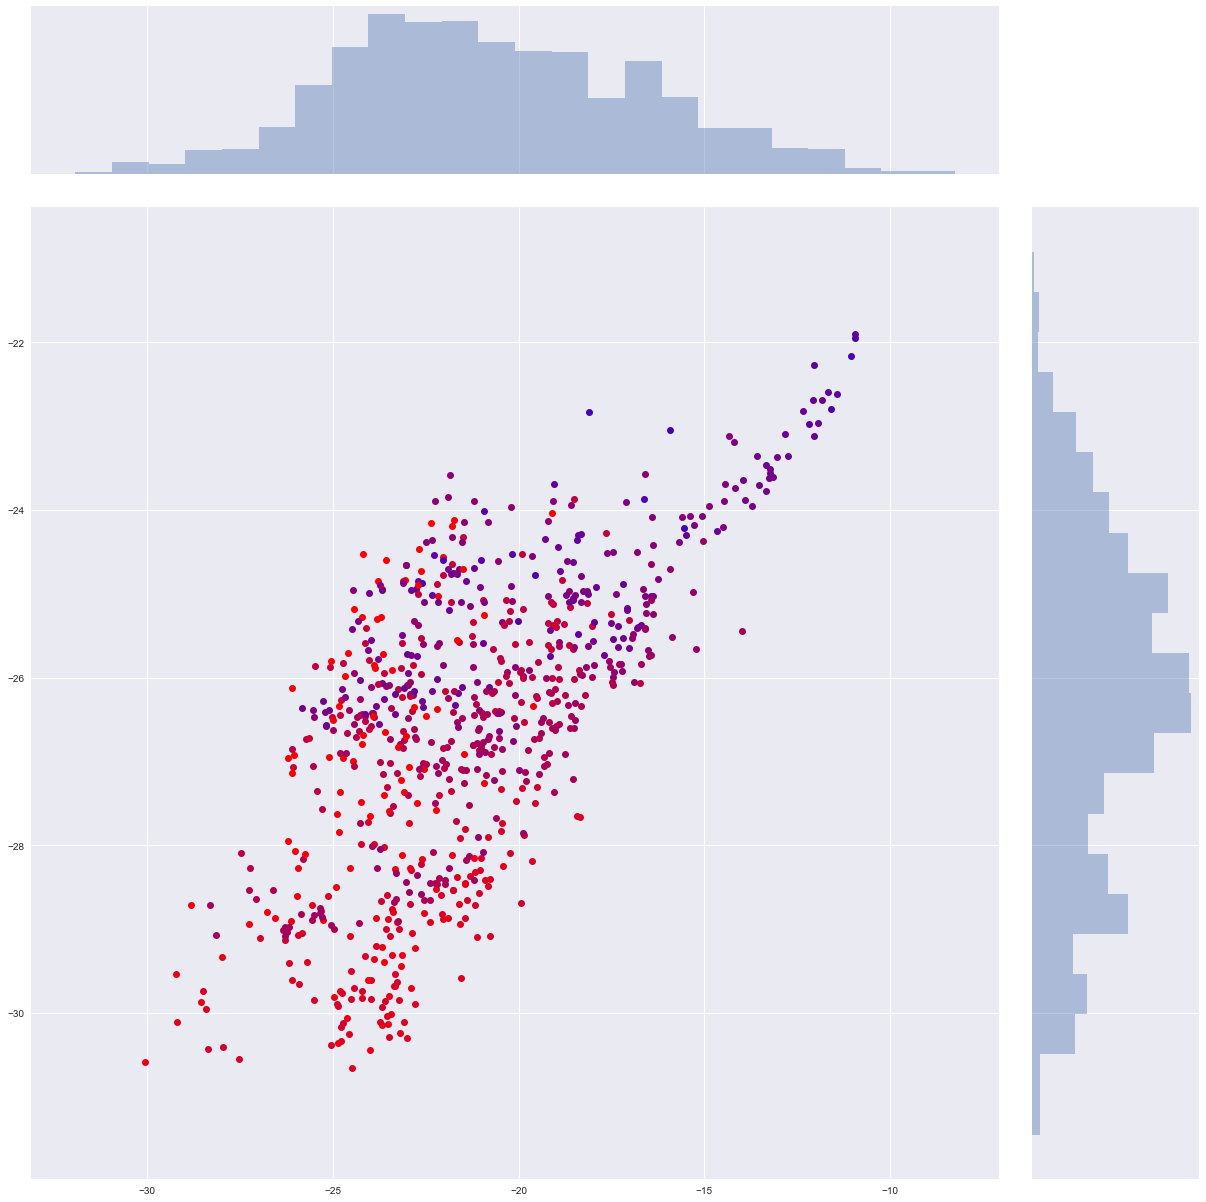

In [16]:
from itertools import product

g = sns.jointplot("band_1_mean", "band_2_mean", data=trainData, stat_func=None, size=17)

#Clear the axes containing the scatter plot
g.ax_joint.cla()

# get max value of angle
maxVal = trainData['inc_angle'].max()
minVal = trainData['inc_angle'].min()

# set heat colors
maxClr = [1, 0, 0] # red
minClr = [0, 0, 1] # blue

# get colors for every scan
color = trainData['inc_angle'].apply(lambda row: happycolors.gradientcolor(minClr, maxClr, minVal, maxVal, row, False))

# lots of lists have been created. unify them.
colors = []
for element in color:
        colors.append(element)

# get column numbers
firstColNum = trainData.columns.get_loc("band_1_mean")
secondColNum = trainData.columns.get_loc("band_2_mean")
thirdColNum = trainData.columns.get_loc("is_iceberg")

#Plot each individual point separately
for i, row in enumerate(trainData.iterrows()):
    if row[1][thirdColNum] == 1:
        g.ax_joint.plot(row[1][firstColNum], 
                        row[1][secondColNum],
                        marker='o',
                        markerfacecolor=colors[i])
    #elif row[1][thirdColNum] == 0:
        #g.ax_joint.plot(row[1][firstColNum], 
         #       row[1][secondColNum],
                #marker='^',
                #markerfacecolor=colors[i])

#### train network to regenerate angles

In [16]:
# prepare source and target data
df_target = trainData["inc_angle"]
df_src = trainData.drop(["id", "is_iceberg", "inc_angle", "band_1", "band_2"], axis=1)

In [18]:
from sklearn.cross_validation import train_test_split

# split train / test data
X_train, X_test, y_train, y_test = train_test_split(df_src,
                                                    df_target, 
                                                    test_size=0.15, 
                                                    random_state=16)

from sklearn import tree
clf = tree.DecisionTreeRegressor()
#from sklearn import linear_model
#clf = linear_model.Lasso(alpha=0.01)

clf = clf.fit(X_train, y_train)

In [19]:
# make a prediction
pred = clf.predict(X_test)
# pack it as dataframe
y_pred = pd.DataFrame(pred)
y_pred.columns = ['Prediction']

# drop index of test data
y_test = y_test.reset_index()
y_test = y_test.drop('index', 1)

# stack test and prediction to have better compareability
df_compare = pd.concat([y_test, y_pred], axis=1)
# sort by test data to make plot look good!
df_compare = df_compare.sort_values(by='inc_angle')

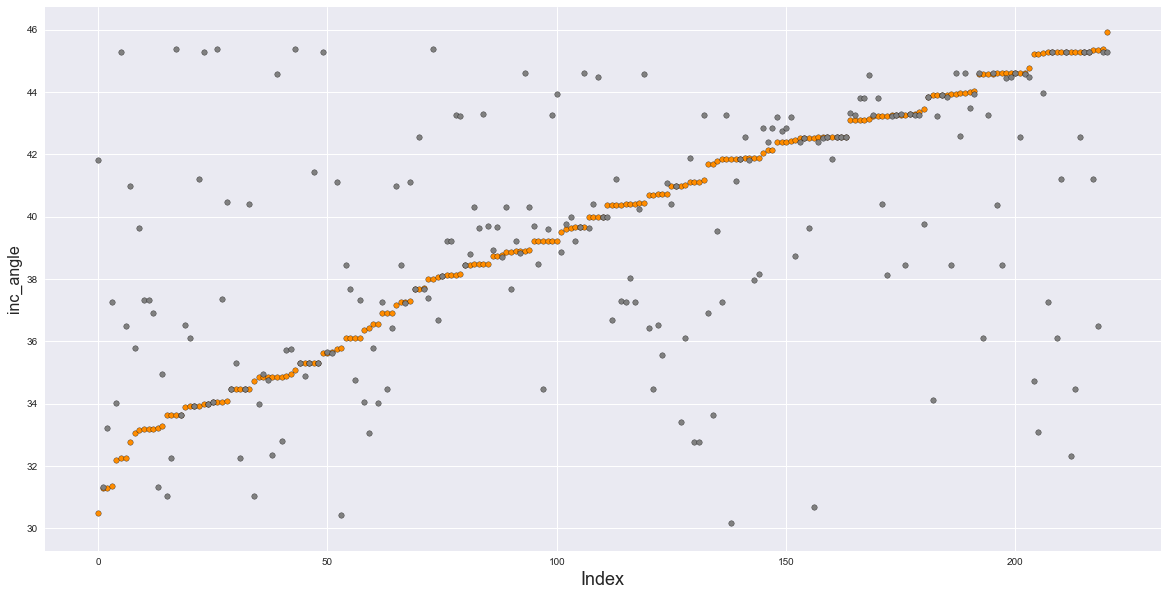

In [20]:
# Plot the results
plt.figure(figsize=(20,10))
plt.scatter(np.arange(0, y_test.shape[0]), df_compare['inc_angle'], s=30, edgecolor="black",
            c="darkorange", label="data")
plt.scatter(np.arange(0, y_test.shape[0]), df_compare['Prediction'], s=30, edgecolor="black",
            c="grey", label="data")
plt.xlabel('Index', fontsize=18)
plt.ylabel('inc_angle', fontsize=16)
plt.show()

#### compute the error that has been made (on dev set)

In [21]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_compare['inc_angle'], df_compare['Prediction'])

2.6594954751131228

#### predict missing angles

In [32]:
# prepare data
df_src = na_trainData.drop(["id", "is_iceberg", "inc_angle", "band_1", "band_2"], axis=1)

# make a prediction
pred = clf.predict(df_src)
# pack it as dataframe
y_pred = pd.DataFrame(pred, index=na_trainData.index)
y_pred.columns = ['Prediction']

# replace na in source data
na_trainData["inc_angle"] = y_pred

,band_1,band_2,id,inc_angle,is_iceberg,band_1_median,band_2_median,band_1_mean,band_2_mean,band_1_std,band_2_std
101,"[-13.271194, -12.898959, -14.867657, -16.54327...","[-22.941357, -23.540695, -24.41008, -24.879778...",f9209504,30.4869,0,-13.026223,-23.968155,-13.082009,-23.989237,2.517823,2.501612
126,"[-22.102318, -23.761854, -26.414414999999998, ...","[-26.414314, -30.252075, -26.730301, -27.39882...",551856d8,44.6676,0,-22.104080,-26.732162,-22.166107,-26.832579,2.176788,2.144250
142,"[-13.514271, -11.831821, -13.580964999999999, ...","[-27.900896, -26.317339, -23.394848, -24.97853...",89842932,37.6866,0,-16.040739,-25.490299,-16.170144,-25.523208,2.317043,2.181969
145,"[-17.553728, -17.245392, -17.553867, -16.85065...","[-25.305712, -24.114067, -25.832432, -25.05414...",f76458ab,37.3796,0,-18.319935,-25.832996,-18.337413,-25.837656,2.371482,2.275217
176,"[-21.199528, -20.517969, -19.016716, -18.10160...","[-21.024048, -20.852085, -22.962326, -25.46114...",9847a428,35.7863,0,-15.634022,-23.410063,-15.317031,-23.371354,3.523832,2.978293
